Experiment,Variable to Change,Fixed Variables,Purpose
1. Sensitivity,"Threshold % (0, 1, 5, 10, 20)",Model: 1.5B  Method: NF4,Find the optimal trade-off (Sweet Spot).
2. Methods,"Method (NF4, AWQ, GPTQ)",Model: 1.5B  Threshold: 5% (or Sweet Spot),Compare KLD impact on different quantizers.
3. Scaling,"Model Size (1.5B, 7B)",Method: (Best of Exp 2)  Threshold: 5%,Test if larger models behave differently.

# **Setup & Dependencies**

**We use L4 GPU**

In [1]:
!pip uninstall transformers torch torchaudio torchvision wandb -y
!pip install llmcompressor
!pip install -q accelerate bitsandbytes datasets scipy matplotlib wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset, concatenate_datasets
from datasets import Dataset
import copy
import gc
import time
from tqdm import tqdm
import shutil
import wandb

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Found existing installation: transformers 4.57.3
Uninstalling transformers-4.57.3:
  Successfully uninstalled transformers-4.57.3
Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: wandb 0.23.1
Uninstalling wandb-0.23.1:
  Successfully uninstalled wandb-0.23.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.2/273.2 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.9/374.9 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Set for reproducibility
import random
import numpy as np
from transformers import set_seed

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## **Experiment 2 Configuration**

In [3]:
# --- Experiment Settings ---
MODELS_TO_TEST = ["Qwen/Qwen2.5-1.5B-Instruct"]
SENSITIVITY_THRESHOLDS = [0.0, 0.05, 0.1, 0.2, 0.3]
CALIBRATION_SAMPLES = 128
EVAL_SAMPLES = 5000
WANDB_PROJECT_NAME = "KLD_Quantization_Exp2"

In [4]:
import wandb
import pandas as pd
from datasets import load_dataset, concatenate_datasets
import os
os.environ["WANDB_QUIET"] = "true"

wandb.login()

if 'results_table' not in globals():
    results_table = []

print("Loading MMLU Dataset...")
try:
    mmlu_dataset = concatenate_datasets([
        load_dataset("cais/mmlu", "all", split='test')
    ])
    print(f"MMLU Dataset Loaded. Size: {len(mmlu_dataset)} samples.")
except Exception as e:
    print(f"Error loading MMLU: {e}")
    from datasets import Dataset
    mmlu_dataset = Dataset.from_dict({
        "question": ["1+1=?"], "choices": [["1", "2", "3", "4"]], "answer": [1]
    })

print("Global setup complete. Ready for Step 2.")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jd4123 (yq171014-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loading MMLU Dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

all/test-00000-of-00001.parquet:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

all/validation-00000-of-00001.parquet:   0%|          | 0.00/408k [00:00<?, ?B/s]

all/dev-00000-of-00001.parquet:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

all/auxiliary_train-00000-of-00001.parqu(…):   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1531 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/285 [00:00<?, ? examples/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

MMLU Dataset Loaded. Size: 14042 samples.
Global setup complete. Ready for Step 2.


## **Metrics & Helper Functions**

In [5]:
def recursive_getattr(obj, attr):
    for part in attr.split('.'):
        obj = getattr(obj, part)
    return obj

def recursive_setattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    parent = recursive_getattr(obj, pre) if pre else obj
    setattr(parent, post, val)

In [6]:
# --- MMLU Logic ---
def format_mmlu_prompt(example):
    options = [f"{label}. {example['choices'][i]}" for i, label in enumerate(['A', 'B', 'C', 'D'])]
    prompt_text = f"Question: {example['question']}\nOptions:\n" + "\n".join(options) + "\nAnswer:"
    messages = [
        {"role": "system", "content": "Output only the single letter (A, B, C, or D) corresponding to the correct answer."},
        {"role": "user", "content": prompt_text}
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

def get_mmlu_predictions(model, dataset, num_samples):
    predictions, ground_truths = [], []
    choices = ["A", "B", "C", "D"]
    choice_ids = [tokenizer.encode(c)[0] for c in choices]

    for i in tqdm(range(min(num_samples, len(dataset))), desc="MMLU Eval"):
        ex = dataset[i]
        inputs = tokenizer(format_mmlu_prompt(ex), return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits[0, -1, choice_ids]
            pred = choices[torch.argmax(logits).item()]
        predictions.append(pred)
        ground_truths.append(choices[ex['answer']])
    return predictions, ground_truths

In [7]:
# --- Metrics Helpers ---
def compute_kld(logits_p, logits_q):
    p_probs = F.softmax(logits_p, dim=-1)
    q_log_probs = F.log_softmax(logits_q, dim=-1)
    return nn.KLDivLoss(reduction='batchmean')(q_log_probs, p_probs).item()

def calculate_flip_rate(base_preds, new_preds):
    """Calculates % of answers that changed from the baseline."""
    if not base_preds or not new_preds: return 0.0
    flips = sum([1 for b, n in zip(base_preds, new_preds) if b != n])
    return flips / len(base_preds)

def compute_perplexity(model, tokenizer):
    """Computes perplexity on a subset of WikiText-2"""
    encodings = tokenizer("\n\n".join(load_dataset("wikitext", "wikitext-2-raw-v1", split="test")["text"][:20]), return_tensors="pt")
    max_length = model.config.max_position_embeddings
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride), desc="Computing PPL"):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            nlls.append(outputs.loss)

        prev_end_loc = end_loc
        if end_loc == seq_len: break

    return torch.exp(torch.stack(nlls).mean()).item()

def measure_efficiency(model, tokenizer, input_text="Hello world"):
    # 1. Cleanup
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()

    # 2. Measure Static Memory (Model Weights Only)
    # This shows the pure effect of quantization storage
    static_mem_bytes = torch.cuda.memory_allocated()
    static_mem_gb = static_mem_bytes / 1024**3

    # 3. Run Inference
    input_ids = tokenizer(input_text, return_tensors="pt").to(device)
    start_time = time.time()
    with torch.no_grad():
        _ = model.generate(**input_ids, max_new_tokens=50, min_new_tokens=50)
    torch.cuda.synchronize()
    end_time = time.time()

    # 4. Measure Peak Memory (Weights + KV Cache + Temp Buffers)
    # This shows the "True Cost" to run the model
    peak_mem_bytes = torch.cuda.max_memory_allocated()
    peak_mem_gb = peak_mem_bytes / 1024**3

    latency = end_time - start_time

    return latency, static_mem_gb, peak_mem_gb

def evaluate_full_suite(model, tokenizer, dataset, metric_name):
    """Runs all metrics and returns them."""
    print(f"--- Evaluating: {metric_name} ---")

    # 1. Accuracy
    preds, truths = get_mmlu_predictions(model, dataset, EVAL_SAMPLES)
    acc = sum([1 for p, g in zip(preds, truths) if p == g]) / len(truths)

    # 2. Perplexity
    ppl = compute_perplexity(model, tokenizer)

    # 3. Efficiency (Unpack 3 values now)
    lat, static_mem, peak_mem = measure_efficiency(model, tokenizer)

    print(f"Results -> Acc: {acc:.2%}, PPL: {ppl:.2f}, Latency: {lat:.2f}s, Static Mem: {static_mem:.2f}GB, Peak Mem: {peak_mem:.2f}GB")

    # Return separate memory metrics
    return acc, ppl, lat, static_mem, peak_mem, preds

## **Advanced Sensitivity Profiling**

In [8]:
def profile_restoration_sensitivity(model_q, model_ref, calib_input, granularity='layer'):
    """
    Profiles sensitivity by measuring the KLD improvement when restoring
    individual parts of the quantized model (model_q) back to FP16 (model_ref).

    Returns:
        sensitivity_scores: Dict mapping name -> KLD improvement (Higher is more sensitive).
    """
    print(f"Profiling Restoration Sensitivity (Granularity: {granularity})...")

    # Compute Baseline
    model_ref.eval()

    with torch.no_grad():
        ref_device = next(model_ref.parameters()).device
        base_logits = model_ref(calib_input.to(ref_device)).logits.to(device)
        current_logits = model_q(calib_input.to(device)).logits
        initial_kld = compute_kld(base_logits, current_logits)

    print(f"Initial Quantized KLD: {initial_kld:.6f}")

    sensitivity_scores = {}

    def get_module_by_name(module, access_string):
        names = access_string.split(sep='.')
        return reduce(getattr, names, module)

    from functools import reduce

    # Block-wise or Layer-wise
    if granularity == 'block':
        if hasattr(model_q, 'model') and hasattr(model_q.model, 'layers'):
            iterable_items = list(enumerate(model_q.model.layers))
            prefix = "model.model.layers"
        else:
            raise ValueError("Could not detect transformer blocks structure.")
        iterator = tqdm(iterable_items, desc="Profiling Blocks")
    elif granularity == 'layer':
        # # We limit this to just the linear layers to save time
        # iterable_items = [(n, m) for n, m in model_q.named_modules() if isinstance(m, (nn.Linear,  import_bnb_linear_type_if_needed()))]
        iterable_items = [(n, m) for n, m in model_q.named_modules()
                          if "mlp" in n or "self_attn" in n]
        iterator = tqdm(iterable_items, desc="Profiling Layers")

    # Restoration Loop
    for name_or_idx, module_q in iterator:
        target_name = f"{prefix}.{name_or_idx}" if granularity == 'block' else name_or_idx
        try:
            module_ref = recursive_getattr(model_ref, target_name)
            backup_quant_module = recursive_getattr(model_q, target_name)
            module_fp16_gpu = copy.deepcopy(module_ref).to(device)
            recursive_setattr(model_q, target_name, module_fp16_gpu)

            # Measure New KLD
            with torch.no_grad():
                new_logits = model_q(calib_input.to(device)).logits
                new_kld = compute_kld(base_logits, new_logits)

            improvement = initial_kld - new_kld
            sensitivity_scores[target_name] = improvement
            recursive_setattr(model_q, target_name, backup_quant_module)

            # Cleanup VRAM
            del module_fp16_gpu

        except Exception as e:
            print(f"Skipping {target_name}: {e}")

    return sensitivity_scores

## **The "Surgery" Implementation**

In [9]:
def perform_surgery(model, sensitive_names, fp16_model_cpu):
    """
    Replaces the sensitive quantized layers in 'model' (GPU)
    with the original FP16 layers from 'fp16_model_cpu' (CPU).

    This Generic Version uses deepcopy, so it works for:
    - Individual Linear layers (gate_proj, q_proj)
    - Entire Blocks (Qwen2MLP, Qwen2Attention)
    """
    count = 0
    print(f"Surgery: Replacing {len(sensitive_names)} Sensitive Layers with FP16...")

    for name in sensitive_names:
        try:
            # 1. Get original FP16 module from CPU backup
            #    (This handles Linear, Qwen2MLP, Qwen2Attention, etc.)
            original_module = recursive_getattr(fp16_model_cpu, name)

            # 2. Create a deep copy and move to GPU
            #    We use deepcopy instead of manually instantiating nn.Linear.
            #    This preserves the exact class type and configuration.
            module_fp16_gpu = copy.deepcopy(original_module).to(model.device)

            # 3. Swap into the quantized model
            recursive_setattr(model, name, module_fp16_gpu)

            count += 1

        except Exception as e:
            print(f"Skipping layer {name}: {e}")

    print(f"Surgery Complete: {count} layers restored.")

# Model Selection & Baseline Evaluation

In [10]:
# Select model
CURRENT_MODEL_ID = MODELS_TO_TEST[0]

print(f"{'='*40}\nSelected Model: {CURRENT_MODEL_ID}\n{'='*40}")

tokenizer = AutoTokenizer.from_pretrained(CURRENT_MODEL_ID)
print("Loading FP16 Baseline (This may take a minute)...")
model_fp16 = AutoModelForCausalLM.from_pretrained(
    CURRENT_MODEL_ID,
    dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

# Evaluate Baseline
base_acc, base_ppl, base_lat, base_static_mem, base_peak_mem, base_preds = evaluate_full_suite(
    model_fp16, tokenizer, mmlu_dataset, "FP16 Baseline"
)

# Log Baseline to WandB
run = wandb.init(project=WANDB_PROJECT_NAME, name=f"{CURRENT_MODEL_ID.split('/')[-1]}-Baseline", reinit=True)
wandb.log({
    "Accuracy": base_acc,
    "Perplexity": base_ppl,
    "Latency": base_lat,
    "Static_Memory": base_static_mem,
    "Peak_Memory": base_peak_mem,
    "Threshold": 0,
    "Flip_Rate": 0.0,
    "Method": "Baseline"
})
run.finish()

# Store in Results Table
results_table.append({
    "Model": CURRENT_MODEL_ID,
    "Method": "FP16 Baseline",
    "Threshold": 0,
    "Acc": base_acc,
    "Flip": 0.0,
    "PPL": base_ppl,
    "Latency": base_lat,
    "Static Mem": base_static_mem,
    "Peak Mem": base_peak_mem
})

print("Baseline Loaded & Evaluated.")

Selected Model: Qwen/Qwen2.5-1.5B-Instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Loading FP16 Baseline (This may take a minute)...


config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

--- Evaluating: FP16 Baseline ---


MMLU Eval: 100%|██████████| 5000/5000 [03:05<00:00, 26.97it/s]


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]


Results -> Acc: 57.36%, PPL: 6.33, Latency: 1.88s, Static Mem: 2.88GB, Peak Mem: 2.89GB


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Baseline Loaded & Evaluated.


In [11]:
# Profiling & Offloading
print("Preparing Calibration Data...")
calib_data = tokenizer(
    "\n\n".join(load_dataset("wikitext", "wikitext-2-raw-v1", split="test")["text"][:10]),
    return_tensors="pt"
).input_ids.to(device)

granularity_mode = 'layer'

# Offload FP16 Model to CPU to save memory
print("Moving FP16 model to CPU to free up VRAM...")
model_fp16.cpu()
torch.cuda.empty_cache()
print("VRAM Cleared. Ready for Experiments.")

Preparing Calibration Data...
Moving FP16 model to CPU to free up VRAM...
VRAM Cleared. Ready for Experiments.


# Preliminary Check:
Justifying the "Base" Precision
Variable: Floating Point Type (FP8 vs. FP4/NF4)

Purpose: Before running complex KLD experiments, you must decide what your "base" low-precision format is. If FP4 destroys the model completely and FP8 is perfect, then KLD is needed for FP4 but not FP8. If both are good, FP4 is better for efficiency.

Design:

Run: 1.5B Model (FP16 Baseline) vs. 1.5B (FP8) vs. 1.5B (NF4).

Metric: Perplexity & MMLU Accuracy.

Hypothesis: NF4 offers higher compression but higher degradation than FP8. This justifies using NF4 (or INT4 methods) as the primary candidate for your KLD restoration because it needs the help more than FP8 does.

Decision: If verified, fix 4-bit (NF4/INT4) as the standard base for the rest of the experiments.

**Refer to the FP8 vs FP4 notebook**

**Results: NF4 offers higher compression but higher degradation than FP8. We will use NF4 (or INT4 methods) as the primary candidate for the following experiments because it needs the help more than FP8 does.**

# Experiment 1: Sensitivity Analysis
Research Question: How much of the model actually needs to be kept in high precision to recover performance? Is there a point of diminishing returns?

Fixed Variables:

Model: Qwen2.5-1.5B (Small enough to run fast, big enough to show signal).

Method: NF4 (The simplest 4-bit baseline).

Independent Variable (Change this):

KLD Threshold / % Restored: 0% (Baseline), 1%, 5%, 10%, 20%.


**Refer to the FP8 vs FP4 notebook**


# Experiment 2: Algorithm Comparison
Research Question: Does KLD guidance work better on top of simple quantization (NF4) or advanced quantization (AWQ/GPTQ)?

Fixed Variables:

Model: Qwen2.5-1.5B (Consistent with Exp 1).

Threshold: Fix this to the "winner" from Exp 1 (e.g., if 5% was the sweet spot, use 5% for all).

Independent Variable (Change this):

Method: NF4 vs. AWQ vs. GPTQ.

Why: AWQ and GPTQ already do some optimization. You want to see if your KLD method adds value on top of them, or if it's only useful for naive methods like NF4.

#### AWQ

In [12]:
from llmcompressor.modifiers.awq import AWQModifier
from llmcompressor.modifiers.quantization import GPTQModifier
from llmcompressor import oneshot

In [13]:
# AWQ
print(f"\n--- Starting Experiment: AWQ ({CURRENT_MODEL_ID}) ---")

print("Running AWQ Oneshot Quantization...")
ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
calib_data_obj = Dataset.from_dict({"text": [text for text in ds["text"] if len(text) > 0][:128]})

recipe = [AWQModifier(targets="Linear", scheme="W4A16")]
oneshot(
    model=CURRENT_MODEL_ID,
    dataset=calib_data_obj,
    recipe=recipe,
    output_dir="./awq_temp",
    num_calibration_samples=128,
    max_seq_length=512,
    save_compressed=True
)

model_awq = AutoModelForCausalLM.from_pretrained(
    "./awq_temp", device_map="auto", trust_remote_code=True
)

print("Profiling AWQ Sensitivity...")
awq_sensitivity = profile_restoration_sensitivity(
    model_q=model_awq,
    model_ref=model_fp16,
    calib_input=calib_data,
    granularity='layer'
)

sorted_awq = sorted(awq_sensitivity.items(), key=lambda x: x[1], reverse=True)
all_layer_names = [n for n, s in sorted_awq]

# Experiment loop
sorted_thresholds = sorted(SENSITIVITY_THRESHOLDS)
current_restored_count = 0

for threshold in sorted_thresholds:
    print(f"\nTargeting Threshold: {threshold:.0%} kept in FP16")

    target_count = int(len(all_layer_names) * threshold)
    layers_to_fix_now = all_layer_names[current_restored_count : target_count]

    if layers_to_fix_now:
        print(f"Restoring {len(layers_to_fix_now)} additional layers...")
        perform_surgery(model_awq, layers_to_fix_now, model_fp16)
        current_restored_count = target_count

    run = wandb.init(
        project=WANDB_PROJECT_NAME,
        name=f"{CURRENT_MODEL_ID.split('/')[-1]}-AWQ-{threshold}",
        config={"model": CURRENT_MODEL_ID, "method": "KLD-AWQ", "threshold": threshold},
        reinit=True
    )

    acc, ppl, lat, static_mem, peak_mem, preds = evaluate_full_suite(
        model_awq, tokenizer, mmlu_dataset, f"KLD-AWQ-{threshold:.0%}"
    )

    flip = calculate_flip_rate(base_preds, preds)

    wandb.log({
        "Accuracy": acc, "Perplexity": ppl, "Latency": lat, "Static_Memory": static_mem,
        "Peak_Memory": peak_mem, "Flip_Rate": flip, "Threshold": threshold
    })

    results_table.append({
        "Model": CURRENT_MODEL_ID,
        "Method": "KLD-AWQ",
        "Threshold": threshold,
        "Acc": acc,
        "Flip": flip,
        "PPL": ppl,
        "Latency": lat,
        "Static Mem": static_mem,
        "Peak Mem": peak_mem
    })
    run.finish()

shutil.rmtree("./awq_temp")
del model_awq
torch.cuda.empty_cache()


--- Starting Experiment: AWQ (Qwen/Qwen2.5-1.5B-Instruct) ---
Running AWQ Oneshot Quantization...


`torch_dtype` is deprecated! Use `dtype` instead!


Tokenizing:   0%|          | 0/128 [00:00<?, ? examples/s]

2025-12-17T15:19:25.592742+0000 | reset | INFO - Compression lifecycle reset
2025-12-17T15:19:25.602138+0000 | _create_default_logger | INFO - Logging all LLM Compressor modifier-level logs to sparse_logs/17-12-2025_15.19.25.log
2025-12-17T15:19:25.603198+0000 | from_modifiers | INFO - Creating recipe from modifiers
2025-12-17T15:19:25.636341+0000 | on_initialize | INFO - No AWQModifier.mappings provided, inferring from model...


Resolving mapping 1/4 (0 skipped): : 28it [00:00, 1221.80it/s]
Resolving mapping 2/4 (27 skipped): : 28it [00:00, 1498.37it/s]
Resolving mapping 3/4 (0 skipped): : 28it [00:00, 1198.58it/s]
Resolving mapping 4/4 (0 skipped): : 28it [00:00, 1261.69it/s]

2025-12-17T15:19:25.737967+0000 | initialize | INFO - Compression lifecycle initialized for 1 modifiers
2025-12-17T15:19:25.738764+0000 | IndependentPipeline | INFO - Inferred `SequentialPipeline` for `AWQModifier`



(29/29): Calibrating: 100%|██████████| 128/128 [00:00<00:00, 163.82it/s]
Smoothing: 0it [00:00, ?it/s]
(29/29): Propagating: 100%|██████████| 128/128 [00:00<00:00, 172.90it/s]
Smoothing: 0it [00:00, ?it/s]
Calibrating weights: 197it [00:02, 74.73it/s]

2025-12-17T15:23:26.017909+0000 | finalize | INFO - Compression lifecycle finalized for 1 modifiers


2025-12-17T15:23:26.074123+0000 | get_model_compressor | INFO - skip_sparsity_compression_stats set to True. Skipping sparsity compression statistic calculations. No sparsity compressor will be applied.


Compressing model: 197it [00:03, 54.67it/s]
Compressing model: 197it [00:00, 1015.77it/s]


Profiling AWQ Sensitivity...
Profiling Restoration Sensitivity (Granularity: layer)...
Initial Quantized KLD: 143.375000


Profiling Layers: 100%|██████████| 280/280 [00:59<00:00,  4.68it/s]



Targeting Threshold: 0% kept in FP16


--- Evaluating: KLD-AWQ-0% ---


Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]


Results -> Acc: 51.90%, PPL: 7.77, Latency: 8.91s, Static Mem: 4.07GB, Peak Mem: 6.25GB



Targeting Threshold: 5% kept in FP16
Restoring 14 additional layers...
Surgery: Replacing 14 Sensitive Layers with FP16...
Surgery Complete: 14 layers restored.


--- Evaluating: KLD-AWQ-5% ---


Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]


Results -> Acc: 51.76%, PPL: 7.75, Latency: 8.50s, Static Mem: 4.03GB, Peak Mem: 6.20GB



Targeting Threshold: 10% kept in FP16
Restoring 14 additional layers...
Surgery: Replacing 14 Sensitive Layers with FP16...
Surgery Complete: 14 layers restored.


--- Evaluating: KLD-AWQ-10% ---


Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]


Results -> Acc: 49.48%, PPL: 7.88, Latency: 8.27s, Static Mem: 4.01GB, Peak Mem: 6.19GB



Targeting Threshold: 20% kept in FP16
Restoring 28 additional layers...
Surgery: Replacing 28 Sensitive Layers with FP16...
Surgery Complete: 28 layers restored.


--- Evaluating: KLD-AWQ-20% ---


Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]


Results -> Acc: 49.40%, PPL: 7.87, Latency: 8.28s, Static Mem: 4.01GB, Peak Mem: 6.19GB



Targeting Threshold: 30% kept in FP16
Restoring 28 additional layers...
Surgery: Replacing 28 Sensitive Layers with FP16...
Surgery Complete: 28 layers restored.


--- Evaluating: KLD-AWQ-30% ---


Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]


Results -> Acc: 46.32%, PPL: 8.27, Latency: 7.74s, Static Mem: 3.96GB, Peak Mem: 6.14GB


#### GPTQ

In [23]:
# GPTQ

print(f"\n--- Starting Experiment: GPTQ ({CURRENT_MODEL_ID}) ---")

print("Running GPTQ Optimization...")
ds = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
calib_data_obj = Dataset.from_dict({"text": [text for text in ds["text"] if len(text) > 0][:128]})

recipe = [
    GPTQModifier(
        targets="Linear",
        scheme="W4A16",
        ignore=["lm_head"],
        dampening_frac=0.01
    )
]

oneshot(
    model=CURRENT_MODEL_ID,
    dataset=calib_data_obj,
    recipe=recipe,
    output_dir="./gptq_temp",
    num_calibration_samples=128,
    max_seq_length=512,
    save_compressed=True
)

model_gptq = AutoModelForCausalLM.from_pretrained(
    "./gptq_temp", device_map="auto", trust_remote_code=True
)

print("Profiling GPTQ Sensitivity...")
gptq_sensitivity = profile_restoration_sensitivity(
    model_q=model_gptq,
    model_ref=model_fp16,
    calib_input=calib_data,
    granularity= 'layer'
)

sorted_gptq = sorted(gptq_sensitivity.items(), key=lambda x: x[1], reverse=True)
all_layer_names = [n for n, s in sorted_gptq]

sorted_thresholds = sorted(SENSITIVITY_THRESHOLDS)
current_restored_count = 0

for threshold in sorted_thresholds:
    print(f"\nTargeting Threshold: {threshold:.0%} kept in FP16")

    target_count = int(len(all_layer_names) * threshold)
    layers_to_fix_now = all_layer_names[current_restored_count : target_count]

    if layers_to_fix_now:
        print(f"Restoring {len(layers_to_fix_now)} additional layers...")
        perform_surgery(model_gptq, layers_to_fix_now, model_fp16)
        current_restored_count = target_count

    run = wandb.init(
        project=WANDB_PROJECT_NAME,
        name=f"{CURRENT_MODEL_ID.split('/')[-1]}-GPTQ-{threshold}",
        config={"model": CURRENT_MODEL_ID, "method": "KLD-GPTQ", "threshold": threshold},
        reinit=True
    )

    acc, ppl, lat, static_mem, peak_mem, preds = evaluate_full_suite(
        model_gptq, tokenizer, mmlu_dataset, f"KLD-GPTQ-{threshold:.0%}"
    )

    flip = calculate_flip_rate(base_preds, preds)

    wandb.log({
        "Accuracy": acc, "Perplexity": ppl, "Latency": lat, "Static_Memory": static_mem,
        "Peak_Memory": peak_mem, "Flip_Rate": flip, "Threshold": threshold
    })

    results_table.append({
        "Model": CURRENT_MODEL_ID,
        "Method": "KLD-GPTQ",
        "Threshold": threshold,
        "Acc": acc,
        "Flip": flip,
        "PPL": ppl,
        "Latency": lat,
        "Static Mem": static_mem,
        "Peak Mem": peak_mem
    })
    run.finish()

shutil.rmtree("./gptq_temp")
del model_gptq
torch.cuda.empty_cache()


--- Starting Experiment: GPTQ (Qwen/Qwen2.5-1.5B-Instruct) ---
Running GPTQ Optimization...


Tokenizing:   0%|          | 0/128 [00:00<?, ? examples/s]

2025-12-17T17:29:35.449002+0000 | reset | INFO - Compression lifecycle reset
2025-12-17T17:29:35.452340+0000 | from_modifiers | INFO - Creating recipe from modifiers
2025-12-17T17:29:35.485384+0000 | initialize | INFO - Compression lifecycle initialized for 1 modifiers
2025-12-17T17:29:35.486306+0000 | IndependentPipeline | INFO - Inferred `SequentialPipeline` for `GPTQModifier`


(1/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 47.89it/s]

2025-12-17T17:29:41.314270+0000 | compress_modules | INFO - Quantizing model.layers.0.self_attn.q_proj using 128 samples


2025-12-17T17:29:42.196749+0000 | compress | METRIC - time 0.88s
2025-12-17T17:29:42.198477+0000 | compress | METRIC - error 710.84
2025-12-17T17:29:42.199572+0000 | compress | METRIC - GPU 0 | usage: 54.09% | total memory: 24 GB
2025-12-17T17:29:42.200473+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:29:42.201485+0000 | compress_modules | INFO - Quantizing model.layers.0.self_attn.k_proj using 128 samples
2025-12-17T17:29:43.043458+0000 | compress | METRIC - time 0.84s
2025-12-17T17:29:43.045139+0000 | compress | METRIC - error 109.73
2025-12-17T17:29:43.046047+0000 | compress | METRIC - GPU 0 | usage: 54.09% | total memory: 24 GB
2025-12-17T17:29:43.046965+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:29:43.047897+0000 | compress_modules | INFO - Quantizing model.layers.0.self_attn.v_proj using 128 samples
2025-12-17T17:29:43.891349+0000 | compress | METRIC - time 0.84s
2025-12-17T17:29:43.893023+0000 | compress | METRIC - e

(2/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.83it/s]

2025-12-17T17:29:56.068300+0000 | compress_modules | INFO - Quantizing model.layers.1.self_attn.q_proj using 128 samples


2025-12-17T17:29:56.955012+0000 | compress | METRIC - time 0.89s
2025-12-17T17:29:56.956646+0000 | compress | METRIC - error 439.80
2025-12-17T17:29:56.957756+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:29:56.958644+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:29:56.959663+0000 | compress_modules | INFO - Quantizing model.layers.1.self_attn.k_proj using 128 samples
2025-12-17T17:29:57.819369+0000 | compress | METRIC - time 0.86s
2025-12-17T17:29:57.820991+0000 | compress | METRIC - error 127.68
2025-12-17T17:29:57.822117+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:29:57.822981+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:29:57.824017+0000 | compress_modules | INFO - Quantizing model.layers.1.self_attn.v_proj using 128 samples
2025-12-17T17:29:58.682563+0000 | compress | METRIC - time 0.86s
2025-12-17T17:29:58.684218+0000 | compress | METRIC - e

(3/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.74it/s]

2025-12-17T17:30:09.517555+0000 | compress_modules | INFO - Quantizing model.layers.2.self_attn.q_proj using 128 samples


2025-12-17T17:30:10.396407+0000 | compress | METRIC - time 0.88s
2025-12-17T17:30:10.398154+0000 | compress | METRIC - error 1234.88
2025-12-17T17:30:10.399261+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:30:10.400148+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:30:10.401278+0000 | compress_modules | INFO - Quantizing model.layers.2.self_attn.k_proj using 128 samples
2025-12-17T17:30:11.247152+0000 | compress | METRIC - time 0.85s
2025-12-17T17:30:11.248870+0000 | compress | METRIC - error 263.37
2025-12-17T17:30:11.249966+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:30:11.250810+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:30:11.251853+0000 | compress_modules | INFO - Quantizing model.layers.2.self_attn.v_proj using 128 samples
2025-12-17T17:30:12.099387+0000 | compress | METRIC - time 0.85s
2025-12-17T17:30:12.101130+0000 | compress | METRIC - 

(4/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.43it/s]

2025-12-17T17:30:22.950210+0000 | compress_modules | INFO - Quantizing model.layers.3.self_attn.q_proj using 128 samples


2025-12-17T17:30:23.826606+0000 | compress | METRIC - time 0.87s
2025-12-17T17:30:23.828360+0000 | compress | METRIC - error 1079.88
2025-12-17T17:30:23.829347+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:30:23.830344+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:30:23.831250+0000 | compress_modules | INFO - Quantizing model.layers.3.self_attn.k_proj using 128 samples
2025-12-17T17:30:24.688442+0000 | compress | METRIC - time 0.86s
2025-12-17T17:30:24.690122+0000 | compress | METRIC - error 228.62
2025-12-17T17:30:24.691104+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:30:24.692061+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:30:24.693209+0000 | compress_modules | INFO - Quantizing model.layers.3.self_attn.v_proj using 128 samples
2025-12-17T17:30:25.564998+0000 | compress | METRIC - time 0.87s
2025-12-17T17:30:25.566849+0000 | compress | METRIC - 

(5/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.31it/s]

2025-12-17T17:30:36.309682+0000 | compress_modules | INFO - Quantizing model.layers.4.self_attn.q_proj using 128 samples


2025-12-17T17:30:37.192915+0000 | compress | METRIC - time 0.88s
2025-12-17T17:30:37.194576+0000 | compress | METRIC - error 1017.54
2025-12-17T17:30:37.195509+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:30:37.196288+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:30:37.197613+0000 | compress_modules | INFO - Quantizing model.layers.4.self_attn.k_proj using 128 samples
2025-12-17T17:30:38.040781+0000 | compress | METRIC - time 0.84s
2025-12-17T17:30:38.042477+0000 | compress | METRIC - error 194.66
2025-12-17T17:30:38.043652+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:30:38.044700+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:30:38.045702+0000 | compress_modules | INFO - Quantizing model.layers.4.self_attn.v_proj using 128 samples
2025-12-17T17:30:38.898362+0000 | compress | METRIC - time 0.85s
2025-12-17T17:30:38.900012+0000 | compress | METRIC - 

(6/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.38it/s]

2025-12-17T17:30:49.627310+0000 | compress_modules | INFO - Quantizing model.layers.5.self_attn.q_proj using 128 samples


2025-12-17T17:30:50.507331+0000 | compress | METRIC - time 0.88s
2025-12-17T17:30:50.509065+0000 | compress | METRIC - error 1087.84
2025-12-17T17:30:50.510218+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:30:50.511177+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:30:50.512447+0000 | compress_modules | INFO - Quantizing model.layers.5.self_attn.k_proj using 128 samples
2025-12-17T17:30:51.380506+0000 | compress | METRIC - time 0.87s
2025-12-17T17:30:51.382245+0000 | compress | METRIC - error 231.78
2025-12-17T17:30:51.383292+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:30:51.384238+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:30:51.385297+0000 | compress_modules | INFO - Quantizing model.layers.5.self_attn.v_proj using 128 samples
2025-12-17T17:30:52.239480+0000 | compress | METRIC - time 0.85s
2025-12-17T17:30:52.241150+0000 | compress | METRIC - 

(7/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.25it/s]

2025-12-17T17:31:03.047603+0000 | compress_modules | INFO - Quantizing model.layers.6.self_attn.q_proj using 128 samples


2025-12-17T17:31:03.924747+0000 | compress | METRIC - time 0.88s
2025-12-17T17:31:03.926443+0000 | compress | METRIC - error 1408.46
2025-12-17T17:31:03.927408+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:31:03.928300+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:31:03.929361+0000 | compress_modules | INFO - Quantizing model.layers.6.self_attn.k_proj using 128 samples
2025-12-17T17:31:04.782928+0000 | compress | METRIC - time 0.85s
2025-12-17T17:31:04.784621+0000 | compress | METRIC - error 293.43
2025-12-17T17:31:04.785554+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:31:04.786460+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:31:04.787479+0000 | compress_modules | INFO - Quantizing model.layers.6.self_attn.v_proj using 128 samples
2025-12-17T17:31:05.642857+0000 | compress | METRIC - time 0.85s
2025-12-17T17:31:05.644531+0000 | compress | METRIC - 

(8/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.37it/s]

2025-12-17T17:31:16.494160+0000 | compress_modules | INFO - Quantizing model.layers.7.self_attn.q_proj using 128 samples


2025-12-17T17:31:17.374039+0000 | compress | METRIC - time 0.88s
2025-12-17T17:31:17.375269+0000 | compress | METRIC - error 742.50
2025-12-17T17:31:17.376182+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:31:17.377023+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:31:17.378048+0000 | compress_modules | INFO - Quantizing model.layers.7.self_attn.k_proj using 128 samples
2025-12-17T17:31:18.220543+0000 | compress | METRIC - time 0.84s
2025-12-17T17:31:18.222276+0000 | compress | METRIC - error 143.96
2025-12-17T17:31:18.223274+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:31:18.224185+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:31:18.225141+0000 | compress_modules | INFO - Quantizing model.layers.7.self_attn.v_proj using 128 samples
2025-12-17T17:31:19.070057+0000 | compress | METRIC - time 0.84s
2025-12-17T17:31:19.071778+0000 | compress | METRIC - e

(9/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.58it/s]

2025-12-17T17:31:29.839202+0000 | compress_modules | INFO - Quantizing model.layers.8.self_attn.q_proj using 128 samples


2025-12-17T17:31:30.719718+0000 | compress | METRIC - time 0.88s
2025-12-17T17:31:30.721526+0000 | compress | METRIC - error 1551.83
2025-12-17T17:31:30.722373+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:31:30.723181+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:31:30.724587+0000 | compress_modules | INFO - Quantizing model.layers.8.self_attn.k_proj using 128 samples
2025-12-17T17:31:31.578388+0000 | compress | METRIC - time 0.85s
2025-12-17T17:31:31.580178+0000 | compress | METRIC - error 272.54
2025-12-17T17:31:31.581170+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:31:31.581918+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:31:31.583025+0000 | compress_modules | INFO - Quantizing model.layers.8.self_attn.v_proj using 128 samples
2025-12-17T17:31:32.442663+0000 | compress | METRIC - time 0.86s
2025-12-17T17:31:32.444394+0000 | compress | METRIC - 

(10/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.56it/s]

2025-12-17T17:31:43.185299+0000 | compress_modules | INFO - Quantizing model.layers.9.self_attn.q_proj using 128 samples


2025-12-17T17:31:44.066091+0000 | compress | METRIC - time 0.88s
2025-12-17T17:31:44.067915+0000 | compress | METRIC - error 1387.63
2025-12-17T17:31:44.068833+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:31:44.069792+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:31:44.070930+0000 | compress_modules | INFO - Quantizing model.layers.9.self_attn.k_proj using 128 samples
2025-12-17T17:31:44.922592+0000 | compress | METRIC - time 0.85s
2025-12-17T17:31:44.924353+0000 | compress | METRIC - error 282.63
2025-12-17T17:31:44.925306+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:31:44.926261+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:31:44.927309+0000 | compress_modules | INFO - Quantizing model.layers.9.self_attn.v_proj using 128 samples
2025-12-17T17:31:45.782271+0000 | compress | METRIC - time 0.85s
2025-12-17T17:31:45.784063+0000 | compress | METRIC - 

(11/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.46it/s]

2025-12-17T17:31:56.522850+0000 | compress_modules | INFO - Quantizing model.layers.10.self_attn.q_proj using 128 samples


2025-12-17T17:31:57.399395+0000 | compress | METRIC - time 0.88s
2025-12-17T17:31:57.401204+0000 | compress | METRIC - error 1389.06
2025-12-17T17:31:57.402189+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:31:57.403152+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:31:57.404157+0000 | compress_modules | INFO - Quantizing model.layers.10.self_attn.k_proj using 128 samples
2025-12-17T17:31:58.249315+0000 | compress | METRIC - time 0.84s
2025-12-17T17:31:58.251098+0000 | compress | METRIC - error 269.79
2025-12-17T17:31:58.251987+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:31:58.253030+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:31:58.254024+0000 | compress_modules | INFO - Quantizing model.layers.10.self_attn.v_proj using 128 samples
2025-12-17T17:31:59.105368+0000 | compress | METRIC - time 0.85s
2025-12-17T17:31:59.107195+0000 | compress | METRIC 

(12/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.26it/s]

2025-12-17T17:32:09.849398+0000 | compress_modules | INFO - Quantizing model.layers.11.self_attn.q_proj using 128 samples


2025-12-17T17:32:10.726085+0000 | compress | METRIC - time 0.87s
2025-12-17T17:32:10.727943+0000 | compress | METRIC - error 1484.53
2025-12-17T17:32:10.728797+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:32:10.729902+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:32:10.731079+0000 | compress_modules | INFO - Quantizing model.layers.11.self_attn.k_proj using 128 samples
2025-12-17T17:32:11.583112+0000 | compress | METRIC - time 0.85s
2025-12-17T17:32:11.584846+0000 | compress | METRIC - error 289.58
2025-12-17T17:32:11.585732+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:32:11.586834+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:32:11.587953+0000 | compress_modules | INFO - Quantizing model.layers.11.self_attn.v_proj using 128 samples
2025-12-17T17:32:12.442023+0000 | compress | METRIC - time 0.85s
2025-12-17T17:32:12.443880+0000 | compress | METRIC 

(13/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.28it/s]

2025-12-17T17:32:23.292408+0000 | compress_modules | INFO - Quantizing model.layers.12.self_attn.q_proj using 128 samples


2025-12-17T17:32:24.173854+0000 | compress | METRIC - time 0.88s
2025-12-17T17:32:24.175654+0000 | compress | METRIC - error 1914.43
2025-12-17T17:32:24.176730+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:32:24.177723+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:32:24.178853+0000 | compress_modules | INFO - Quantizing model.layers.12.self_attn.k_proj using 128 samples
2025-12-17T17:32:25.033362+0000 | compress | METRIC - time 0.85s
2025-12-17T17:32:25.035131+0000 | compress | METRIC - error 409.37
2025-12-17T17:32:25.036029+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:32:25.036986+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:32:25.037999+0000 | compress_modules | INFO - Quantizing model.layers.12.self_attn.v_proj using 128 samples
2025-12-17T17:32:25.903499+0000 | compress | METRIC - time 0.86s
2025-12-17T17:32:25.905283+0000 | compress | METRIC 

(14/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.39it/s]

2025-12-17T17:32:36.685825+0000 | compress_modules | INFO - Quantizing model.layers.13.self_attn.q_proj using 128 samples


2025-12-17T17:32:37.568933+0000 | compress | METRIC - time 0.88s
2025-12-17T17:32:37.570757+0000 | compress | METRIC - error 1355.15
2025-12-17T17:32:37.571608+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:32:37.572399+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:32:37.573570+0000 | compress_modules | INFO - Quantizing model.layers.13.self_attn.k_proj using 128 samples
2025-12-17T17:32:38.432931+0000 | compress | METRIC - time 0.86s
2025-12-17T17:32:38.434744+0000 | compress | METRIC - error 272.29
2025-12-17T17:32:38.435735+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:32:38.436570+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:32:38.437905+0000 | compress_modules | INFO - Quantizing model.layers.13.self_attn.v_proj using 128 samples
2025-12-17T17:32:39.351890+0000 | compress | METRIC - time 0.91s
2025-12-17T17:32:39.353844+0000 | compress | METRIC 

(15/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.54it/s]

2025-12-17T17:32:50.061020+0000 | compress_modules | INFO - Quantizing model.layers.14.self_attn.q_proj using 128 samples


2025-12-17T17:32:50.942109+0000 | compress | METRIC - time 0.88s
2025-12-17T17:32:50.944227+0000 | compress | METRIC - error 2625.83
2025-12-17T17:32:50.945497+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:32:50.946750+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:32:50.947976+0000 | compress_modules | INFO - Quantizing model.layers.14.self_attn.k_proj using 128 samples
2025-12-17T17:32:51.801593+0000 | compress | METRIC - time 0.85s
2025-12-17T17:32:51.803414+0000 | compress | METRIC - error 393.71
2025-12-17T17:32:51.804463+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:32:51.805450+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:32:51.806545+0000 | compress_modules | INFO - Quantizing model.layers.14.self_attn.v_proj using 128 samples
2025-12-17T17:32:52.661414+0000 | compress | METRIC - time 0.85s
2025-12-17T17:32:52.663507+0000 | compress | METRIC 

(16/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.48it/s]

2025-12-17T17:33:03.399339+0000 | compress_modules | INFO - Quantizing model.layers.15.self_attn.q_proj using 128 samples


2025-12-17T17:33:04.272412+0000 | compress | METRIC - time 0.87s
2025-12-17T17:33:04.274264+0000 | compress | METRIC - error 2947.85
2025-12-17T17:33:04.275181+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:33:04.276104+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:33:04.277451+0000 | compress_modules | INFO - Quantizing model.layers.15.self_attn.k_proj using 128 samples
2025-12-17T17:33:05.133951+0000 | compress | METRIC - time 0.86s
2025-12-17T17:33:05.135718+0000 | compress | METRIC - error 329.30
2025-12-17T17:33:05.136511+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:33:05.137210+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:33:05.138249+0000 | compress_modules | INFO - Quantizing model.layers.15.self_attn.v_proj using 128 samples
2025-12-17T17:33:05.992437+0000 | compress | METRIC - time 0.85s
2025-12-17T17:33:05.994276+0000 | compress | METRIC 

(17/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.38it/s]

2025-12-17T17:33:16.708794+0000 | compress_modules | INFO - Quantizing model.layers.16.self_attn.q_proj using 128 samples


2025-12-17T17:33:17.583053+0000 | compress | METRIC - time 0.87s
2025-12-17T17:33:17.584866+0000 | compress | METRIC - error 2560.46
2025-12-17T17:33:17.585817+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:33:17.586720+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:33:17.587620+0000 | compress_modules | INFO - Quantizing model.layers.16.self_attn.k_proj using 128 samples
2025-12-17T17:33:18.441324+0000 | compress | METRIC - time 0.85s
2025-12-17T17:33:18.443137+0000 | compress | METRIC - error 478.53
2025-12-17T17:33:18.444052+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:33:18.444872+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:33:18.445838+0000 | compress_modules | INFO - Quantizing model.layers.16.self_attn.v_proj using 128 samples
2025-12-17T17:33:19.297463+0000 | compress | METRIC - time 0.85s
2025-12-17T17:33:19.299306+0000 | compress | METRIC 

(18/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.43it/s]

2025-12-17T17:33:30.036841+0000 | compress_modules | INFO - Quantizing model.layers.17.self_attn.q_proj using 128 samples


2025-12-17T17:33:30.917087+0000 | compress | METRIC - time 0.88s
2025-12-17T17:33:30.918900+0000 | compress | METRIC - error 2247.22
2025-12-17T17:33:30.919840+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:33:30.920589+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:33:30.921650+0000 | compress_modules | INFO - Quantizing model.layers.17.self_attn.k_proj using 128 samples
2025-12-17T17:33:31.772893+0000 | compress | METRIC - time 0.85s
2025-12-17T17:33:31.774780+0000 | compress | METRIC - error 276.19
2025-12-17T17:33:31.775750+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:33:31.776586+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:33:31.777619+0000 | compress_modules | INFO - Quantizing model.layers.17.self_attn.v_proj using 128 samples
2025-12-17T17:33:32.630482+0000 | compress | METRIC - time 0.85s
2025-12-17T17:33:32.632412+0000 | compress | METRIC 

(19/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.35it/s]

2025-12-17T17:33:43.375536+0000 | compress_modules | INFO - Quantizing model.layers.18.self_attn.q_proj using 128 samples


2025-12-17T17:33:44.241585+0000 | compress | METRIC - time 0.86s
2025-12-17T17:33:44.243427+0000 | compress | METRIC - error 1811.89
2025-12-17T17:33:44.244366+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:33:44.245420+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:33:44.246540+0000 | compress_modules | INFO - Quantizing model.layers.18.self_attn.k_proj using 128 samples
2025-12-17T17:33:45.097551+0000 | compress | METRIC - time 0.85s
2025-12-17T17:33:45.099385+0000 | compress | METRIC - error 303.22
2025-12-17T17:33:45.100425+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:33:45.101430+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:33:45.102496+0000 | compress_modules | INFO - Quantizing model.layers.18.self_attn.v_proj using 128 samples
2025-12-17T17:33:45.957673+0000 | compress | METRIC - time 0.85s
2025-12-17T17:33:45.959547+0000 | compress | METRIC 

(20/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.60it/s]

2025-12-17T17:33:56.703164+0000 | compress_modules | INFO - Quantizing model.layers.19.self_attn.q_proj using 128 samples


2025-12-17T17:33:57.582143+0000 | compress | METRIC - time 0.88s
2025-12-17T17:33:57.583980+0000 | compress | METRIC - error 2425.97
2025-12-17T17:33:57.584830+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:33:57.585690+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:33:57.587021+0000 | compress_modules | INFO - Quantizing model.layers.19.self_attn.k_proj using 128 samples
2025-12-17T17:33:58.435154+0000 | compress | METRIC - time 0.85s
2025-12-17T17:33:58.437003+0000 | compress | METRIC - error 320.36
2025-12-17T17:33:58.438057+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:33:58.438821+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:33:58.440058+0000 | compress_modules | INFO - Quantizing model.layers.19.self_attn.v_proj using 128 samples
2025-12-17T17:33:59.290187+0000 | compress | METRIC - time 0.85s
2025-12-17T17:33:59.292027+0000 | compress | METRIC 

(21/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.43it/s]

2025-12-17T17:34:10.033996+0000 | compress_modules | INFO - Quantizing model.layers.20.self_attn.q_proj using 128 samples


2025-12-17T17:34:10.910452+0000 | compress | METRIC - time 0.87s
2025-12-17T17:34:10.912260+0000 | compress | METRIC - error 3112.94
2025-12-17T17:34:10.913404+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:34:10.914266+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:34:10.915297+0000 | compress_modules | INFO - Quantizing model.layers.20.self_attn.k_proj using 128 samples
2025-12-17T17:34:11.768907+0000 | compress | METRIC - time 0.85s
2025-12-17T17:34:11.770734+0000 | compress | METRIC - error 391.45
2025-12-17T17:34:11.771906+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:34:11.772831+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:34:11.773934+0000 | compress_modules | INFO - Quantizing model.layers.20.self_attn.v_proj using 128 samples
2025-12-17T17:34:12.623770+0000 | compress | METRIC - time 0.85s
2025-12-17T17:34:12.625623+0000 | compress | METRIC 

(22/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.40it/s]

2025-12-17T17:34:23.391405+0000 | compress_modules | INFO - Quantizing model.layers.21.self_attn.q_proj using 128 samples


2025-12-17T17:34:24.274470+0000 | compress | METRIC - time 0.88s
2025-12-17T17:34:24.276401+0000 | compress | METRIC - error 3031.80
2025-12-17T17:34:24.277399+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:34:24.278339+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:34:24.279475+0000 | compress_modules | INFO - Quantizing model.layers.21.self_attn.k_proj using 128 samples
2025-12-17T17:34:25.130595+0000 | compress | METRIC - time 0.85s
2025-12-17T17:34:25.132383+0000 | compress | METRIC - error 370.73
2025-12-17T17:34:25.133651+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:34:25.134618+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:34:25.135720+0000 | compress_modules | INFO - Quantizing model.layers.21.self_attn.v_proj using 128 samples
2025-12-17T17:34:25.989587+0000 | compress | METRIC - time 0.85s
2025-12-17T17:34:25.991745+0000 | compress | METRIC 

(23/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.52it/s]

2025-12-17T17:34:36.767526+0000 | compress_modules | INFO - Quantizing model.layers.22.self_attn.q_proj using 128 samples


2025-12-17T17:34:37.649752+0000 | compress | METRIC - time 0.88s
2025-12-17T17:34:37.651566+0000 | compress | METRIC - error 2877.54
2025-12-17T17:34:37.652569+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:34:37.653517+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:34:37.654605+0000 | compress_modules | INFO - Quantizing model.layers.22.self_attn.k_proj using 128 samples
2025-12-17T17:34:38.514285+0000 | compress | METRIC - time 0.86s
2025-12-17T17:34:38.516198+0000 | compress | METRIC - error 434.05
2025-12-17T17:34:38.517239+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:34:38.518017+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:34:38.519301+0000 | compress_modules | INFO - Quantizing model.layers.22.self_attn.v_proj using 128 samples
2025-12-17T17:34:39.397600+0000 | compress | METRIC - time 0.88s
2025-12-17T17:34:39.399515+0000 | compress | METRIC 

(24/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.34it/s]

2025-12-17T17:34:50.146576+0000 | compress_modules | INFO - Quantizing model.layers.23.self_attn.q_proj using 128 samples


2025-12-17T17:34:51.012450+0000 | compress | METRIC - time 0.86s
2025-12-17T17:34:51.014357+0000 | compress | METRIC - error 4116.78
2025-12-17T17:34:51.015335+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:34:51.016360+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:34:51.017572+0000 | compress_modules | INFO - Quantizing model.layers.23.self_attn.k_proj using 128 samples
2025-12-17T17:34:51.885588+0000 | compress | METRIC - time 0.87s
2025-12-17T17:34:51.887574+0000 | compress | METRIC - error 482.21
2025-12-17T17:34:51.888761+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:34:51.889811+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:34:51.890780+0000 | compress_modules | INFO - Quantizing model.layers.23.self_attn.v_proj using 128 samples
2025-12-17T17:34:52.769112+0000 | compress | METRIC - time 0.88s
2025-12-17T17:34:52.770965+0000 | compress | METRIC 

(25/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.28it/s]

2025-12-17T17:35:03.503198+0000 | compress_modules | INFO - Quantizing model.layers.24.self_attn.q_proj using 128 samples


2025-12-17T17:35:04.400831+0000 | compress | METRIC - time 0.90s
2025-12-17T17:35:04.402620+0000 | compress | METRIC - error 3719.51
2025-12-17T17:35:04.403458+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:35:04.404425+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:35:04.405645+0000 | compress_modules | INFO - Quantizing model.layers.24.self_attn.k_proj using 128 samples
2025-12-17T17:35:05.244028+0000 | compress | METRIC - time 0.84s
2025-12-17T17:35:05.245886+0000 | compress | METRIC - error 494.89
2025-12-17T17:35:05.246799+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:35:05.247570+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:35:05.248453+0000 | compress_modules | INFO - Quantizing model.layers.24.self_attn.v_proj using 128 samples
2025-12-17T17:35:06.087605+0000 | compress | METRIC - time 0.84s
2025-12-17T17:35:06.089538+0000 | compress | METRIC 

(26/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.25it/s]

2025-12-17T17:35:16.814969+0000 | compress_modules | INFO - Quantizing model.layers.25.self_attn.q_proj using 128 samples


2025-12-17T17:35:17.694109+0000 | compress | METRIC - time 0.88s
2025-12-17T17:35:17.695907+0000 | compress | METRIC - error 4440.95
2025-12-17T17:35:17.696805+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:35:17.697491+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:35:17.698587+0000 | compress_modules | INFO - Quantizing model.layers.25.self_attn.k_proj using 128 samples
2025-12-17T17:35:18.553718+0000 | compress | METRIC - time 0.85s
2025-12-17T17:35:18.555527+0000 | compress | METRIC - error 466.63
2025-12-17T17:35:18.556449+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:35:18.557248+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:35:18.558113+0000 | compress_modules | INFO - Quantizing model.layers.25.self_attn.v_proj using 128 samples
2025-12-17T17:35:19.419499+0000 | compress | METRIC - time 0.86s
2025-12-17T17:35:19.421300+0000 | compress | METRIC 

(27/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.40it/s]

2025-12-17T17:35:30.179679+0000 | compress_modules | INFO - Quantizing model.layers.26.self_attn.q_proj using 128 samples


2025-12-17T17:35:31.041358+0000 | compress | METRIC - time 0.86s
2025-12-17T17:35:31.043309+0000 | compress | METRIC - error 4560.39
2025-12-17T17:35:31.044530+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:35:31.045480+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:35:31.046800+0000 | compress_modules | INFO - Quantizing model.layers.26.self_attn.k_proj using 128 samples
2025-12-17T17:35:31.890896+0000 | compress | METRIC - time 0.84s
2025-12-17T17:35:31.892730+0000 | compress | METRIC - error 568.22
2025-12-17T17:35:31.893539+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:35:31.894321+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:35:31.895278+0000 | compress_modules | INFO - Quantizing model.layers.26.self_attn.v_proj using 128 samples
2025-12-17T17:35:32.754081+0000 | compress | METRIC - time 0.86s
2025-12-17T17:35:32.755996+0000 | compress | METRIC 

(28/29): Calibrating: 100%|██████████| 128/128 [00:02<00:00, 56.58it/s]

2025-12-17T17:35:43.487468+0000 | compress_modules | INFO - Quantizing model.layers.27.self_attn.q_proj using 128 samples


2025-12-17T17:35:44.361327+0000 | compress | METRIC - time 0.87s
2025-12-17T17:35:44.363182+0000 | compress | METRIC - error 4339.49
2025-12-17T17:35:44.364034+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:35:44.364741+0000 | compress | METRIC - Compressed module size: 4.77696 MB
2025-12-17T17:35:44.365735+0000 | compress_modules | INFO - Quantizing model.layers.27.self_attn.k_proj using 128 samples
2025-12-17T17:35:45.212821+0000 | compress | METRIC - time 0.85s
2025-12-17T17:35:45.214696+0000 | compress | METRIC - error 460.15
2025-12-17T17:35:45.215643+0000 | compress | METRIC - GPU 0 | usage: 52.15% | total memory: 24 GB
2025-12-17T17:35:45.216778+0000 | compress | METRIC - Compressed module size: 0.79616 MB
2025-12-17T17:35:45.217908+0000 | compress_modules | INFO - Quantizing model.layers.27.self_attn.v_proj using 128 samples
2025-12-17T17:35:46.075552+0000 | compress | METRIC - time 0.86s
2025-12-17T17:35:46.077434+0000 | compress | METRIC 

(29/29): Propagating: 100%|██████████| 128/128 [00:00<00:00, 170.49it/s]


2025-12-17T17:35:56.499876+0000 | finalize | INFO - Compression lifecycle finalized for 1 modifiers
2025-12-17T17:35:56.553808+0000 | get_model_compressor | INFO - skip_sparsity_compression_stats set to True. Skipping sparsity compression statistic calculations. No sparsity compressor will be applied.


Compressing model: 196it [00:03, 57.19it/s]
Compressing model: 196it [00:00, 968.25it/s] 


Profiling GPTQ Sensitivity...
Profiling Restoration Sensitivity (Granularity: layer)...
Initial Quantized KLD: 42.406250


Profiling Layers: 100%|██████████| 280/280 [00:53<00:00,  5.25it/s]



Targeting Threshold: 0% kept in FP16


--- Evaluating: KLD-GPTQ-0% ---


Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]


Results -> Acc: 53.08%, PPL: 6.62, Latency: 7.51s, Static Mem: 3.96GB, Peak Mem: 4.10GB



Targeting Threshold: 5% kept in FP16
Restoring 14 additional layers...
Surgery: Replacing 14 Sensitive Layers with FP16...
Surgery Complete: 14 layers restored.


--- Evaluating: KLD-GPTQ-5% ---


Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]


Results -> Acc: 52.98%, PPL: 6.44, Latency: 6.34s, Static Mem: 3.79GB, Peak Mem: 3.92GB



Targeting Threshold: 10% kept in FP16
Restoring 14 additional layers...
Surgery: Replacing 14 Sensitive Layers with FP16...
Surgery Complete: 14 layers restored.


--- Evaluating: KLD-GPTQ-10% ---


Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]


Results -> Acc: 52.30%, PPL: 6.42, Latency: 5.40s, Static Mem: 3.68GB, Peak Mem: 3.81GB



Targeting Threshold: 20% kept in FP16
Restoring 28 additional layers...
Surgery: Replacing 28 Sensitive Layers with FP16...
Surgery Complete: 28 layers restored.


--- Evaluating: KLD-GPTQ-20% ---


Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]


Results -> Acc: 54.44%, PPL: 6.39, Latency: 4.13s, Static Mem: 3.53GB, Peak Mem: 3.66GB



Targeting Threshold: 30% kept in FP16
Restoring 28 additional layers...
Surgery: Replacing 28 Sensitive Layers with FP16...
Surgery Complete: 28 layers restored.


--- Evaluating: KLD-GPTQ-30% ---


Computing PPL:   0%|          | 0/3 [00:00<?, ?it/s]


Results -> Acc: 53.56%, PPL: 6.35, Latency: 3.13s, Static Mem: 3.44GB, Peak Mem: 3.57GB


### Visualization

                         Model         Method  Threshold     Acc    Flip  \
0   Qwen/Qwen2.5-1.5B-Instruct  FP16 Baseline       0.00  0.5736  0.0000   
1   Qwen/Qwen2.5-1.5B-Instruct        KLD-AWQ       0.00  0.5190  0.2884   
2   Qwen/Qwen2.5-1.5B-Instruct        KLD-AWQ       0.05  0.5176  0.3142   
3   Qwen/Qwen2.5-1.5B-Instruct        KLD-AWQ       0.10  0.4948  0.3498   
4   Qwen/Qwen2.5-1.5B-Instruct        KLD-AWQ       0.20  0.4940  0.3504   
5   Qwen/Qwen2.5-1.5B-Instruct        KLD-AWQ       0.30  0.4632  0.4368   
6   Qwen/Qwen2.5-1.5B-Instruct       KLD-GPTQ       0.00  0.5308  0.2604   
7   Qwen/Qwen2.5-1.5B-Instruct       KLD-GPTQ       0.05  0.5298  0.2668   
8   Qwen/Qwen2.5-1.5B-Instruct       KLD-GPTQ       0.10  0.5230  0.2734   
9   Qwen/Qwen2.5-1.5B-Instruct       KLD-GPTQ       0.20  0.5444  0.2264   
10  Qwen/Qwen2.5-1.5B-Instruct       KLD-GPTQ       0.30  0.5356  0.2102   

         PPL   Latency  Static Mem  Peak Mem  
0   6.329750  1.883693    2.883327  2.89

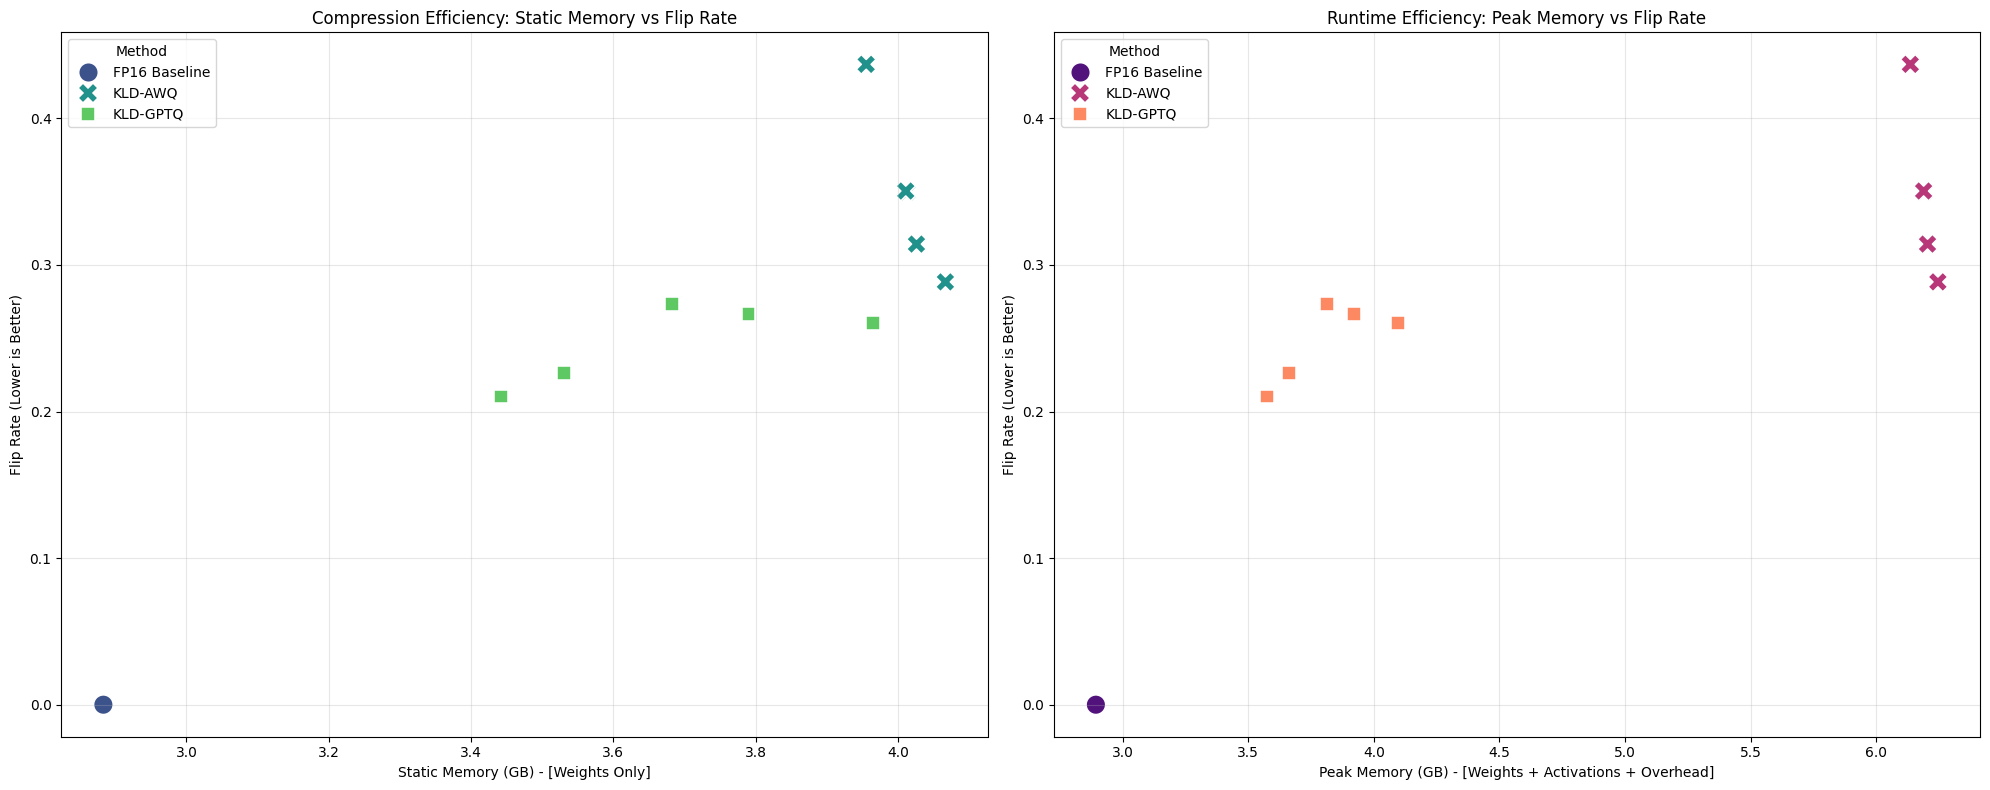

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create DataFrame
df = pd.DataFrame(results_table)

# Display the data
print(df)

# 2. Set up the figure with 2 subplots (Static vs Peak)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- Plot A: Static Memory (Model Size) vs Flip Rate ---
sns.scatterplot(
    data=df, x='Static Mem', y='Flip', hue='Method', style='Method',
    s=200, palette='viridis', ax=axes[0]
)
axes[0].set_title("Compression Efficiency: Static Memory vs Flip Rate")
axes[0].set_xlabel("Static Memory (GB) - [Weights Only]")
axes[0].set_ylabel("Flip Rate (Lower is Better)")
axes[0].grid(True, alpha=0.3)

# Add labels for Plot A
for i in range(df.shape[0]):
    row = df.iloc[i]
    # Check if 'Static_Mem' exists to avoid errors
    if 'Static_Mem' in row:
        axes[0].text(row.Static_Mem + 0.01, row.Flip + 0.001, f"{row.Threshold:.0%}", fontsize=9)

# --- Plot B: Peak Memory (Runtime Cost) vs Flip Rate ---
sns.scatterplot(
    data=df, x='Peak Mem', y='Flip', hue='Method', style='Method',
    s=200, palette='magma', ax=axes[1]
)
axes[1].set_title("Runtime Efficiency: Peak Memory vs Flip Rate")
axes[1].set_xlabel("Peak Memory (GB) - [Weights + Activations + Overhead]")
axes[1].set_ylabel("Flip Rate (Lower is Better)")
axes[1].grid(True, alpha=0.3)

# Add labels for Plot B
for i in range(df.shape[0]):
    row = df.iloc[i]
    if 'Peak_Mem' in row:
        axes[1].text(row.Peak_Mem + 0.05, row.Flip + 0.001, f"{row.Threshold:.0%}", fontsize=9)

plt.tight_layout()
plt.savefig("efficiency_frontier_comparison_Experiment2.png")
plt.show()

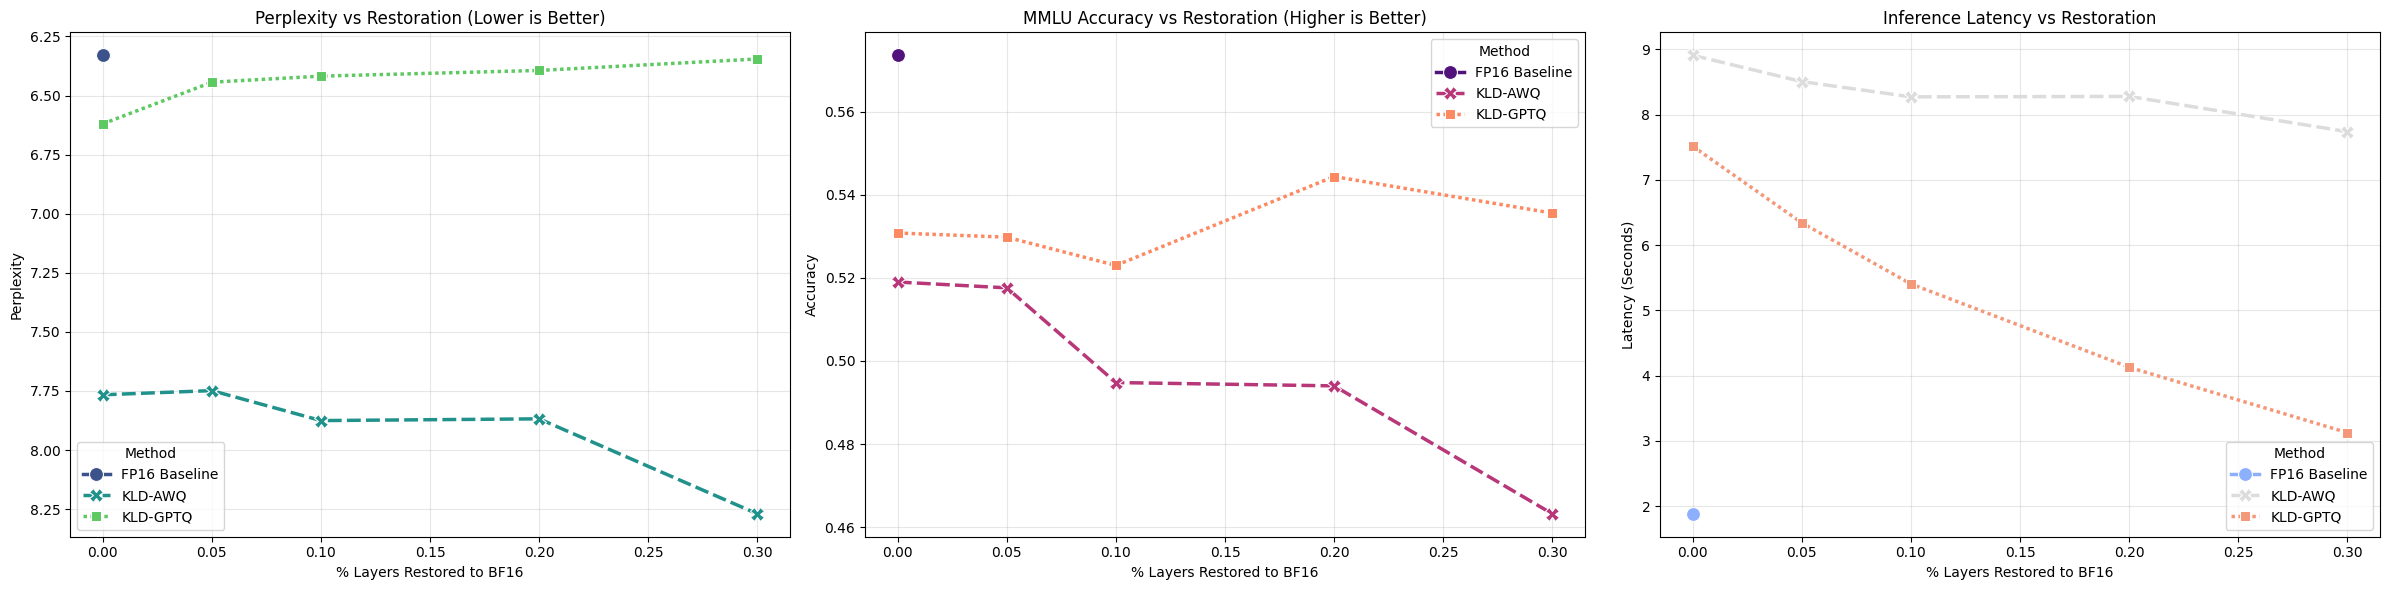

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure DataFrame is ready
df = pd.DataFrame(results_table)

# Set up the figure with 3 subplots side-by-side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# --- Plot 1: Perplexity (Lower is Better) ---
sns.lineplot(
    data=df, x='Threshold', y='PPL', hue='Method', style='Method',
    markers=True, markersize=10, linewidth=2.5, ax=axes[0], palette='viridis'
)
axes[0].set_title("Perplexity vs Restoration (Lower is Better)")
axes[0].set_xlabel("% Layers Restored to BF16")
axes[0].set_ylabel("Perplexity")
axes[0].grid(True, alpha=0.3)
axes[0].invert_yaxis() # Optional: If you want 'better' (lower) to be higher up, remove if standard view preferred.

# --- Plot 2: Accuracy (Higher is Better) ---
sns.lineplot(
    data=df, x='Threshold', y='Acc', hue='Method', style='Method',
    markers=True, markersize=10, linewidth=2.5, ax=axes[1], palette='magma'
)
axes[1].set_title("MMLU Accuracy vs Restoration (Higher is Better)")
axes[1].set_xlabel("% Layers Restored to BF16")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True, alpha=0.3)

# --- Plot 3: Latency (Lower is Better) ---
sns.lineplot(
    data=df, x='Threshold', y='Latency', hue='Method', style='Method',
    markers=True, markersize=10, linewidth=2.5, ax=axes[2], palette='coolwarm'
)
axes[2].set_title("Inference Latency vs Restoration")
axes[2].set_xlabel("% Layers Restored to BF16")
axes[2].set_ylabel("Latency (Seconds)")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("metrics_comparison_Experiment2.png")
plt.show()

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import pandas as pd
import os
import shutil # Import shutil for copying files

# Define the directory to save files in Google Drive
save_dir = '/content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Jiayi/exp2'
os.makedirs(save_dir, exist_ok=True)

# Save results_table as CSV
df_results = pd.DataFrame(results_table)
df_results.to_csv(os.path.join(save_dir, 'exp2_results.csv'), index=False)
print(f"Results table saved to {os.path.join(save_dir, 'exp2_results.csv')}") # Corrected print statement

# Copy figures to Google Drive
figures_to_copy = [
    'efficiency_frontier_comparison_Experiment2.png',
    'metrics_comparison_Experiment2.png'
]

for fig_name in figures_to_copy:
    fig_path = os.path.join('/content', fig_name)
    if os.path.exists(fig_path):
        # Use shutil.copy2 to copy the file, then os.remove to delete the original
        shutil.copy2(fig_path, os.path.join(save_dir, fig_name))
        # os.remove(fig_path) # Remove original after copying
        print(f"Copied {fig_name} to {os.path.join(save_dir, fig_name)} and removed original.")
    else:
        print(f"Figure {fig_name} not found in current directory.")

Results table saved to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Jiayi/exp2/exp2_results.csv
Copied efficiency_frontier_comparison_Experiment2.png to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Jiayi/exp2/efficiency_frontier_comparison_Experiment2.png and removed original.
Copied metrics_comparison_Experiment2.png to /content/drive/MyDrive/Columbia-LLMSeminar/SLLM project/Jiayi/exp2/metrics_comparison_Experiment2.png and removed original.


# Experiment 3: Model Size
Research Question: Does this technique generalize to larger models? (Larger models are usually more robust to quantization; do they need less restoration?)

Fixed Variables:

Method: The "Winner" from Exp 2 (likely NF4 for speed or AWQ for accuracy).

Threshold: Fix to the "sweet spot" (e.g., 5%).

Independent Variable (Change this):

Model Size: 1.5B vs. 7B.